<a href="https://colab.research.google.com/github/TonmoyTalukder/Face-Clustering/blob/main/Face_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Face Clustering
**Author:** [Tonmoy Talukder](https://tonmoytalukder.github.io/)

**Vision:** The objective is to facilitate image grouping for various individuals. Users input an image of a specific person, and the system suggests additional images that match the input. This deep learning solution enables users to easily identify and collect their own images from a diverse set, allowing them to curate their personalized gallery effortlessly.

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Installs

In [11]:
%%capture
!pip install opencv-python scikit-learn tensorflow matplotlib
!pip install facenet-pytorch
!pip install keras-applications
!pip install transformers torch torchvision

## Images

In [19]:
def imagePathGen(n):
    part1 = '/content/drive/MyDrive/ML Projects/Face Clustering/Image/img'
    part2 = '.jpg'

    if isinstance(n, int):
        # If n is a single integer, convert it to a list
        n = [n]

    return [part1 + str(i).zfill(2) + part2 for i in n]


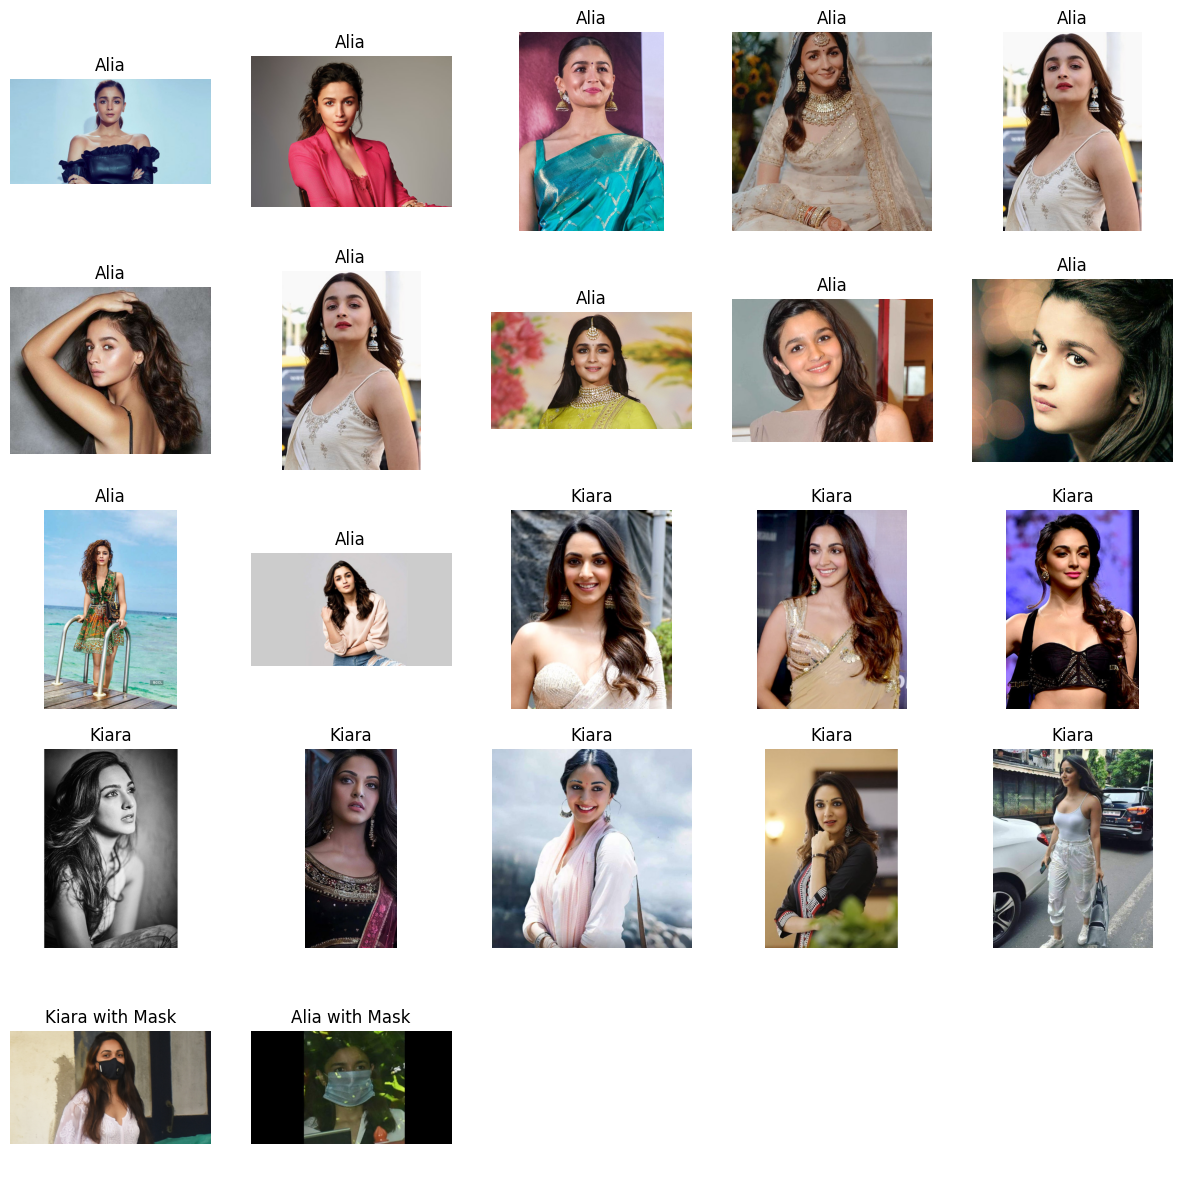

In [53]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Function to display images in rows with labels
def display_images_in_rows_with_labels(image_paths, labels, num_images_per_row=5):
    num_images = len(image_paths)
    num_rows = (num_images + num_images_per_row - 1) // num_images_per_row

    fig, axs = plt.subplots(num_rows, num_images_per_row, figsize=(15, 3 * num_rows))

    for i in range(num_rows):
        for j in range(num_images_per_row):
            index = i * num_images_per_row + j
            if index < num_images:
                img_path = image_paths[index]
                img_label = labels[index]

                axs[i, j].imshow(mpimg.imread(img_path))
                axs[i, j].axis('off')
                axs[i, j].set_title(img_label)

    # Remove any empty subplots in the last row
    if num_images % num_images_per_row != 0:
        for j in range(num_images % num_images_per_row, num_images_per_row):
            axs[num_rows - 1, j].axis('off')

    plt.show()

# Generate image paths and labels for numbers 1 to 22
image_numbers = list(range(1, 23))
all_image_paths = imagePathGen(image_numbers)
image_labels = ['Alia' if 1 <= i <= 12 else 'Alia with Mask' if i == 22 else 'Kiara with Mask' if i == 21 else 'Kiara' for i in image_numbers]

# Display all images in rows with labels
display_images_in_rows_with_labels(all_image_paths, image_labels, num_images_per_row=5)

## Without Deep Embedded Clustering

In [42]:
from sklearn.decomposition import PCA
from PIL import Image, ImageDraw
import torch
from transformers import CLIPProcessor, CLIPModel
from facenet_pytorch import InceptionResnetV1, MTCNN
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch16")
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch16")

resnet = InceptionResnetV1(pretrained='casia-webface').eval()
mtcnn = MTCNN()

mtcnn2 = MTCNN(keep_all=True)

def extract_clip_features(image_paths):
    # Load and preprocess the images
    images = [processor(text="", images=Image.open(image_path), return_tensors="pt") for image_path in image_paths]

    # Encode images
    inputs = torch.stack([image.pixel_values.squeeze(0) for image in images], dim=0)
    features = model.vision_model(inputs)

    # Normalize features
    features = torch.nn.functional.normalize(features['last_hidden_state'].mean(dim=1), p=2, dim=1).detach().numpy()

    return features

def extract_face_features(image_paths):
    face_features = []
    for image_path in image_paths:
        img = Image.open(image_path)
        aligned = mtcnn(img)
        if aligned is not None:
            embeddings = resnet(aligned.unsqueeze(0)).detach().numpy()
            face_features.append(embeddings.squeeze(0))
        else:
            # If no face is detected, you may want to handle this case accordingly
            pass

    return np.array(face_features)

def extract_upper_face_features(image_paths, target_feature_length=512):
    reference_upper_face_features_array = []  # Initialize as an empty list

    for image_path in image_paths:
        img = Image.open(image_path)

        # Initialize MTCNN for face detection
        boxes, _ = mtcnn2.detect(img)

        if boxes is not None and len(boxes) > 0:
            box = boxes[0]

            # Extract upper portion of the face
            upper_face = img.crop((box[0], box[1], box[2], box[1] + (box[3] - box[1]) // 2))

            # Resize the upper face to the target feature length
            upper_face = upper_face.resize((target_feature_length, target_feature_length))

            # Convert to NumPy array
            upper_face_array = np.array(upper_face)

            reference_upper_face_features_array.append(upper_face_array.flatten())
        else:
            print(f"No face detected in {image_path}")

    if reference_upper_face_features_array:  # Check if the list is not empty
        return np.array(reference_upper_face_features_array)
    else:
        return np.array([])  # Return an empty array if no faces are detected

def cluster_images(reference_features, all_features, reference_image_path, image_paths, clip_weight, face_weight, upper_face_weight):
    # Extract facial features for each reference image
    reference_face_features = extract_face_features([reference_image_path])
    all_face_features = extract_face_features(image_paths)

    # Make sure dimensions match
    reference_face_features = np.repeat(reference_face_features, reference_features.shape[1] // reference_face_features.shape[1], axis=1)
    all_face_features = np.repeat(all_face_features, all_features.shape[1] // all_face_features.shape[1], axis=1)

    # Combine facial features with CLIP features using weights
    reference_combined_features = np.concatenate((clip_weight * reference_features, face_weight * reference_face_features), axis=1)
    all_combined_features = np.concatenate((clip_weight * all_features, face_weight * all_face_features), axis=1)

    # Extract upper face features for each reference image
    reference_upper_face_features = extract_upper_face_features([reference_image_path])
    all_upper_face_features = extract_upper_face_features(image_paths)

    # Make sure dimensions match
    reference_upper_face_features = np.repeat(reference_upper_face_features, reference_features.shape[1] // reference_upper_face_features.shape[1], axis=1)
    all_upper_face_features = np.repeat(all_upper_face_features, all_features.shape[1] // all_upper_face_features.shape[1], axis=1)

    # Combine upper face features with CLIP and facial features using weights
    reference_combined_features = np.concatenate((reference_combined_features, upper_face_weight * reference_upper_face_features), axis=1)
    all_combined_features = np.concatenate((all_combined_features, upper_face_weight * all_upper_face_features), axis=1)

    num_clusters= 2

    # Apply k-means clustering
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans.fit(all_combined_features)

    # Find the cluster of the reference image
    reference_cluster = kmeans.predict(reference_combined_features.reshape(1, -1))

    # Find images in the same cluster as the reference image
    cluster_indices = np.where(kmeans.labels_ == reference_cluster)[0]

    # Display the images in the same cluster
    fig, axs = plt.subplots(1, len(cluster_indices) + 1, figsize=(12, 4))

    # Display the reference image
    axs[0].imshow(mpimg.imread(reference_image_path))
    axs[0].axis('off')
    axs[0].set_title('Reference Image')

    # Display the images in the same cluster
    for i, index in enumerate(cluster_indices):
        img_path = image_paths[index]
        axs[i+1].imshow(mpimg.imread(img_path))
        axs[i+1].axis('off')
        axs[i+1].set_title(f'Image {i+1}')

    plt.show()

### Inference

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


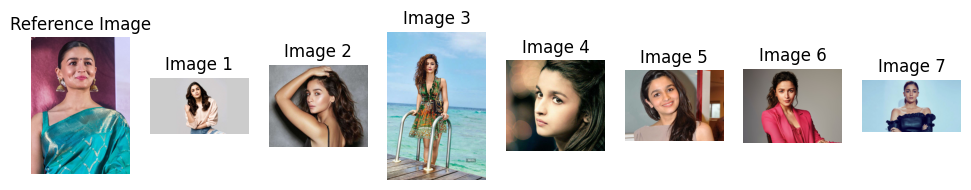

In [24]:
# Example usage
ref_img = 3
imgs = [12, 4, 8, 13, 5, 7, 6, 11, 10, 9, 15, 2, 14, 1]

'''
Images numbered 1 to 12 and 22 are of Alia Bhatt.
Images numbered 13 to 21 are of Kiara Advani.
Images 21 and 22 feature individuals wearing masks.
In this exanple, most of the images are Alia's.
Reference is Alia's one image.
Found only Alia's images in the result.
'''

reference_image_path = imagePathGen(ref_img)[0]
image_paths = imagePathGen(imgs)

# Extract CLIP and facial features
reference_features = extract_clip_features([reference_image_path])
all_features = extract_clip_features(image_paths)

# Get cluster and plot images
cluster_images(reference_features, all_features, reference_image_path, image_paths, clip_weight=0.6, face_weight=0.5, upper_face_weight=0.3)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


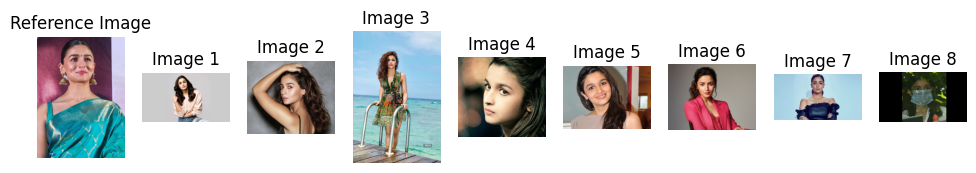

In [25]:
# Example usage
ref_img = 3
imgs = [12, 4, 8, 13, 5, 7, 6, 11, 10, 9, 15, 2, 14, 1, 22]

'''
Images numbered 1 to 12 and 22 are of Alia Bhatt.
Images numbered 13 to 21 are of Kiara Advani.
Images 21 and 22 feature individuals wearing masks.
In this exanple, most of the images are Alia's.
Reference is Alia's one image. Found only Alia's images in the result.
Ali's mask image is inclued and found in the result.
'''

reference_image_path = imagePathGen(ref_img)[0]
image_paths = imagePathGen(imgs)

# Extract CLIP and facial features
reference_features = extract_clip_features([reference_image_path])
all_features = extract_clip_features(image_paths)

# Get cluster and plot images
cluster_images(reference_features, all_features, reference_image_path, image_paths, clip_weight=0.6, face_weight=0.5, upper_face_weight=0.3)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


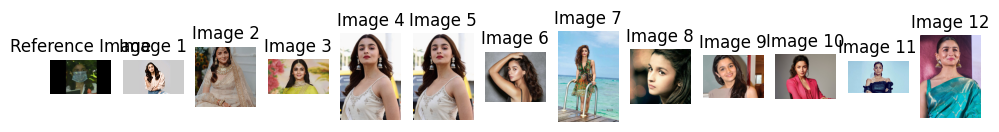

In [26]:
# Example usage
ref_img = 22
imgs = [12, 4, 8, 13, 5, 7, 6, 11, 10, 9, 15, 2, 14, 1, 3]

'''
Images numbered 1 to 12 and 22 are of Alia Bhatt.
Images numbered 13 to 21 are of Kiara Advani.
Images 21 and 22 feature individuals wearing masks.
In this exanple, most of the images are Alia's.
Ali's mask image is used as reference and found only Alia's other images in the result.
'''

reference_image_path = imagePathGen(ref_img)[0]
image_paths = imagePathGen(imgs)

# Extract CLIP and facial features
reference_features = extract_clip_features([reference_image_path])
all_features = extract_clip_features(image_paths)

# Get cluster and plot images
cluster_images(reference_features, all_features, reference_image_path, image_paths, clip_weight=0.6, face_weight=0.5, upper_face_weight=0.3)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


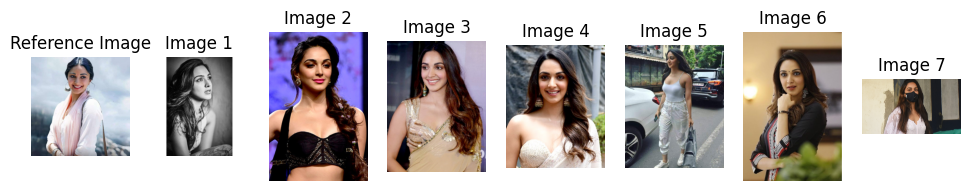

In [28]:
# Example usage
ref_img = 18
imgs = [16, 15, 14, 8, 11, 7, 9, 13, 17, 20, 19, 12, 10, 21]


'''
Images numbered 1 to 12 and 22 are of Alia Bhatt.
Images numbered 13 to 21 are of Kiara Advani.
Images 21 and 22 feature individuals wearing masks.
In this exanple, most of the images are Kiara's.
Reference is Kiara's one image. Found only Kiara's images in the result.
Kiara's mask image is inclued and found in the result.
'''

reference_image_path = imagePathGen(ref_img)[0]
image_paths = imagePathGen(imgs)

# Extract CLIP and facial features
reference_features = extract_clip_features([reference_image_path])
all_features = extract_clip_features(image_paths)

# Get cluster and plot images
cluster_images(reference_features, all_features, reference_image_path, image_paths, clip_weight=0.6, face_weight=0.5, upper_face_weight=0.3)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


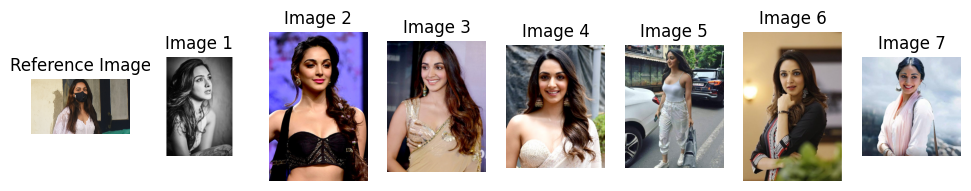

In [29]:
# Example usage
ref_img = 21
imgs = [16, 15, 14, 8, 11, 7, 9, 13, 17, 20, 19, 12, 10, 18]

'''
Images numbered 1 to 12 and 22 are of Alia Bhatt.
Images numbered 13 to 21 are of Kiara Advani.
Images 21 and 22 feature individuals wearing masks.
In this exanple, most of the images are Kiara's.
Kiara's mask image is used as reference and found only Kiara's other images in the result.
'''

reference_image_path = imagePathGen(ref_img)[0]
image_paths = imagePathGen(imgs)

# Extract CLIP and facial features
reference_features = extract_clip_features([reference_image_path])
all_features = extract_clip_features(image_paths)

# Get cluster and plot images
cluster_images(reference_features, all_features, reference_image_path, image_paths, clip_weight=0.6, face_weight=0.5, upper_face_weight=0.3)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


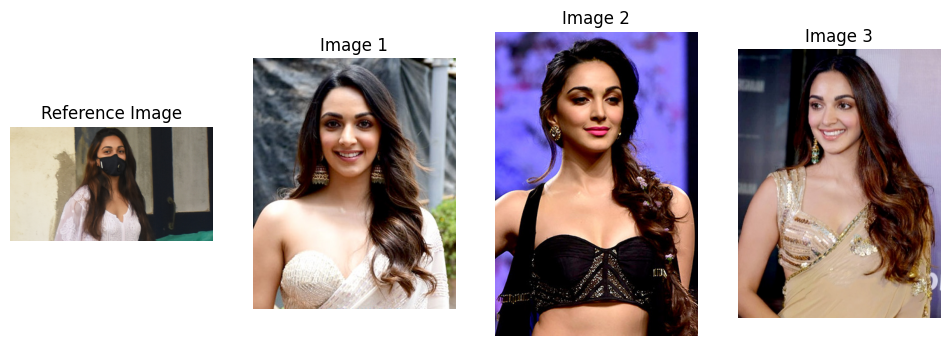

In [30]:
# Example usage
ref_img = 21
imgs = [12, 4, 8, 13, 5, 7, 6, 11, 10, 9, 15, 2, 14, 1, 3]

'''
Images numbered 1 to 12 and 22 are of Alia Bhatt.
Images numbered 13 to 21 are of Kiara Advani.
Images 21 and 22 feature individuals wearing masks.
In this exanple, most of the images are Alia's.
Kiara's mask image is used as reference and found only Kiara's other images in the result.
'''

reference_image_path = imagePathGen(ref_img)[0]
image_paths = imagePathGen(imgs)

# Extract CLIP and facial features
reference_features = extract_clip_features([reference_image_path])
all_features = extract_clip_features(image_paths)

# Get cluster and plot images
cluster_images(reference_features, all_features, reference_image_path, image_paths, clip_weight=0.6, face_weight=0.5, upper_face_weight=0.3)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


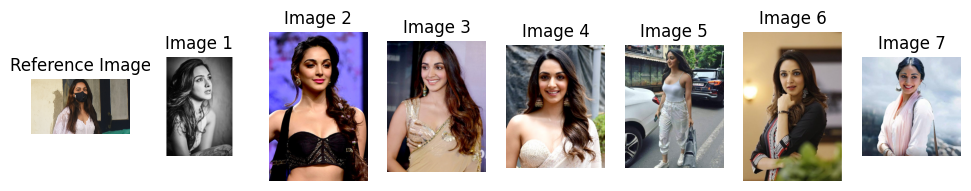

In [47]:
# Example usage
ref_img = 21
imgs = [16, 15, 14, 8, 11, 7, 9, 22, 13, 17, 20, 19, 12, 10, 18]

'''
Images numbered 1 to 12 and 22 are of Alia Bhatt.
Images numbered 13 to 21 are of Kiara Advani.
Images 21 and 22 feature individuals wearing masks.
In this exanple, most of the images are Kiara's with both's mask image.
Kiara's mask image is used as reference and found only Kiara's other images in the result.
'''

reference_image_path = imagePathGen(ref_img)[0]
image_paths = imagePathGen(imgs)

# Extract CLIP and facial features
reference_features = extract_clip_features([reference_image_path])
all_features = extract_clip_features(image_paths)

# Get cluster and plot images
cluster_images(reference_features, all_features, reference_image_path, image_paths, clip_weight=0.6, face_weight=0.5, upper_face_weight=0.3)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


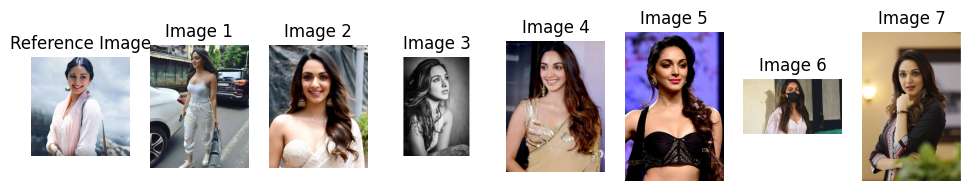

In [43]:
# Example usage
ref_img = 18
imgs = [10, 20, 13, 8, 17, 6, 16, 14, 7, 15, 4, 12, 2, 21, 19, 22, 9]

'''
Images numbered 1 to 12 and 22 are of Alia Bhatt.
Images numbered 13 to 21 are of Kiara Advani.
Images 21 and 22 feature individuals wearing masks.
In this exanple, both have same numbers of images.
Reference is Kiara's one image.
Both's mask images are included and found only Kiara's other images with her mask image in the result.
'''

reference_image_path = imagePathGen(ref_img)[0]
image_paths = imagePathGen(imgs)

# Extract CLIP and facial features
reference_features = extract_clip_features([reference_image_path])
all_features = extract_clip_features(image_paths)

# Get cluster and plot images
cluster_images(reference_features, all_features, reference_image_path, image_paths, clip_weight=0.6, face_weight=0.5, upper_face_weight=0.3)

## With Deep Embedded Clustering

In [31]:
from PIL import Image, ImageDraw
import torch
from facenet_pytorch import InceptionResnetV1, MTCNN
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from torchvision import models, transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class Autoencoder(nn.Module):
    def __init__(self, input_size, encoding_size):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, encoding_size),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_size, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, input_size),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

def train_autoencoder(data_loader, model, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        for inputs in data_loader:
            inputs = inputs[0].to(device)
            outputs = model(inputs)

            # Adjust the target size to match the original input size
            target = inputs.view_as(outputs)

            loss = criterion(outputs, target)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()


def extract_autoencoder_features(model, data_loader):
    model.eval()
    features = []
    with torch.no_grad():
        for inputs in data_loader:
            inputs = inputs[0].to(device)  # Fix here
            outputs = model.encoder(inputs)
            features.append(outputs.cpu().numpy())
    features = np.concatenate(features, axis=0)
    return features

# Load the ResNet152 model pre-trained on ImageNet
resnet152 = models.resnet152(pretrained=True)
resnet152 = nn.Sequential(*list(resnet152.children())[:-1])  # Remove the last fully connected layer

resnet = InceptionResnetV1(pretrained='casia-webface').eval()
mtcnn = MTCNN()

mtcnn2 = MTCNN(keep_all=True)

def extract_clip_features(image_paths):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    features = []

    for image_path in image_paths:
        img = Image.open(image_path).convert("RGB")
        img = transform(img)
        img = img.unsqueeze(0)  # Add batch dimension

        with torch.no_grad():
            resnet152.eval()
            features.append(resnet152(img).squeeze().numpy())

    features = np.array(features)
    return features

def extract_face_features(image_paths):
    face_features = []
    for image_path in image_paths:
        img = Image.open(image_path)
        aligned = mtcnn(img)
        if aligned is not None:
            embeddings = resnet(aligned.unsqueeze(0)).detach().numpy()
            face_features.append(embeddings.squeeze(0))
        else:
            # If no face is detected, you may want to handle this case accordingly
            pass

    return np.array(face_features)

def extract_upper_face_features(image_paths, target_feature_length=512):
    reference_upper_face_features_array = []  # Initialize as an empty list

    for image_path in image_paths:
        img = Image.open(image_path)

        # Initialize MTCNN for face detection
        boxes, _ = mtcnn2.detect(img)

        if boxes is not None and len(boxes) > 0:
            box = boxes[0]

            # Extract upper portion of the face
            upper_face = img.crop((box[0], box[1], box[2], box[1] + (box[3] - box[1]) // 2))

            # Resize the upper face to the target feature length
            upper_face = upper_face.resize((target_feature_length, target_feature_length))

            # Convert to NumPy array
            upper_face_array = np.array(upper_face)

            reference_upper_face_features_array.append(upper_face_array.flatten())
        else:
            print(f"No face detected in {image_path}")

    if reference_upper_face_features_array:  # Check if the list is not empty
        return np.array(reference_upper_face_features_array)
    else:
        return np.array([])  # Return an empty array if no faces are detected

def cluster_images_autoencoder(reference_features, all_features, reference_image_path, image_paths, clip_weight, face_weight, upper_face_weight):

    # Extract facial features for each reference image
    reference_face_features = extract_face_features([reference_image_path])
    all_face_features = extract_face_features(image_paths)

    # Make sure dimensions match
    reference_face_features = np.repeat(reference_face_features, reference_features.shape[1] // reference_face_features.shape[1], axis=1)
    all_face_features = np.repeat(all_face_features, all_features.shape[1] // all_face_features.shape[1], axis=1)

    # Extract upper face features for each reference image
    reference_upper_face_features = extract_upper_face_features([reference_image_path])
    all_upper_face_features = extract_upper_face_features(image_paths)

    # Make sure dimensions match
    reference_upper_face_features = np.repeat(reference_upper_face_features, reference_features.shape[1] // reference_upper_face_features.shape[1], axis=1)
    all_upper_face_features = np.repeat(all_upper_face_features, all_features.shape[1] // all_upper_face_features.shape[1], axis=1)

    # Use a simple autoencoder for feature learning
    autoencoder = Autoencoder(input_size=reference_face_features.shape[1], encoding_size=128)
    autoencoder.to(device)

    # Prepare data loaders
    reference_face_loader = DataLoader(TensorDataset(torch.from_numpy(reference_face_features).float()), batch_size=64, shuffle=True)
    all_face_loader = DataLoader(TensorDataset(torch.from_numpy(all_face_features).float()), batch_size=64, shuffle=False)

    # Train the autoencoder
    criterion = nn.MSELoss()
    optimizer = optim.Adam(autoencoder.parameters(), lr=0.01)
    train_autoencoder(reference_face_loader, autoencoder, criterion, optimizer)

    # Extract autoencoder face features
    reference_autoencoder_face_features = extract_autoencoder_features(autoencoder, reference_face_loader)
    all_autoencoder_face_features = extract_autoencoder_features(autoencoder, all_face_loader)

    # Combine autoencoder features with CLIP features
    reference_combined_features_autoencoder = np.concatenate((clip_weight * reference_features, face_weight * reference_autoencoder_face_features, upper_face_weight * reference_upper_face_features), axis=1)
    all_combined_features_autoencoder = np.concatenate((clip_weight * all_features, face_weight * all_autoencoder_face_features, upper_face_weight * all_upper_face_features), axis=1)

    # Apply k-means clustering on the autoencoder features
    kmeans_autoencoder = KMeans(n_clusters=2, random_state=42)
    kmeans_autoencoder.fit(all_combined_features_autoencoder)
    labels_autoencoder = kmeans_autoencoder.labels_

    # Find the cluster of the reference image
    reference_cluster_autoencoder = kmeans_autoencoder.predict(reference_combined_features_autoencoder.reshape(1, -1))

    # Find images in the same cluster as the reference image
    cluster_indices_autoencoder = np.where(labels_autoencoder == reference_cluster_autoencoder)[0]

    print(cluster_indices_autoencoder)
    print(image_paths)

    fig, axs_ref = plt.subplots(1, 1, figsize=(6, 3))
    axs_ref.imshow(mpimg.imread(reference_image_path))
    axs_ref.axis('off')
    axs_ref.set_title('Reference Image (Deep Embedded Clustering Features)')

    # Display other images in the second plot
    fig, axs_other = plt.subplots(1, len(cluster_indices_autoencoder), figsize=(12, 3))

    for i, index in enumerate(cluster_indices_autoencoder):
        img_path = image_paths[index]
        axs_other[i].imshow(mpimg.imread(img_path))
        axs_other[i].axis('off')
        axs_other[i].set_title(f'Image {i+1}')

    plt.show()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth
100%|██████████| 230M/230M [00:01<00:00, 132MB/s]


### Inference

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[0 1 2 3 4 6]
['/content/drive/MyDrive/ML Projects/Face Clustering/Image/img06.jpg', '/content/drive/MyDrive/ML Projects/Face Clustering/Image/img04.jpg', '/content/drive/MyDrive/ML Projects/Face Clustering/Image/img02.jpg', '/content/drive/MyDrive/ML Projects/Face Clustering/Image/img08.jpg', '/content/drive/MyDrive/ML Projects/Face Clustering/Image/img09.jpg', '/content/drive/MyDrive/ML Projects/Face Clustering/Image/img10.jpg', '/content/drive/MyDrive/ML Projects/Face Clustering/Image/img12.jpg']


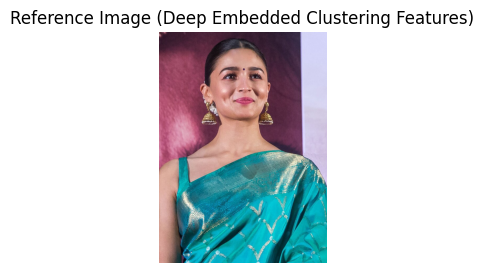

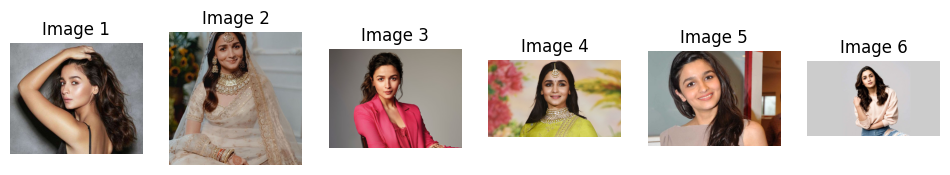

In [32]:
# Example usage
ref_img = 3
imgs = [12, 4, 8, 13, 5, 7, 6, 11, 10, 9, 15, 2, 14, 1]

'''
Images numbered 1 to 12 and 22 are of Alia Bhatt.
Images numbered 13 to 21 are of Kiara Advani.
Images 21 and 22 feature individuals wearing masks.
In this exanple, most of the images are Alia's.
Reference is Alia's one image.
Result is showing only Alia's Images.
'''

reference_image_path = imagePathGen(ref_img)[0]
image_paths = imagePathGen(imgs)

# Extract CLIP and facial features
reference_features = extract_clip_features([reference_image_path])
all_features = extract_clip_features(image_paths)

# Get cluster and plot images
cluster_images(reference_features, all_features, reference_image_path, image_paths, clip_weight=0.6, face_weight=0.5, upper_face_weight=0.3)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


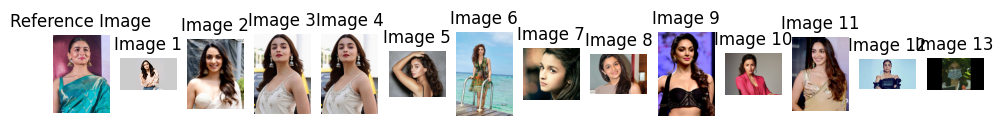

In [33]:
# Example usage
ref_img = 3
imgs = [12, 4, 8, 13, 5, 7, 6, 11, 10, 9, 15, 2, 14, 1, 22]

'''
Images numbered 1 to 12 and 22 are of Alia Bhatt.
Images numbered 13 to 21 are of Kiara Advani.
Images 21 and 22 feature individuals wearing masks.
In this exanple, most of the images are Alia's.
Reference is Alia's one image.
Ali's mask image is inclued and found in the result.
Result is showing Alia's Images with three Kirara's images.
'''

reference_image_path = imagePathGen(ref_img)[0]
image_paths = imagePathGen(imgs)

# Extract CLIP and facial features
reference_features = extract_clip_features([reference_image_path])
all_features = extract_clip_features(image_paths)

# Get cluster and plot images
cluster_images(reference_features, all_features, reference_image_path, image_paths, clip_weight=0.6, face_weight=0.5, upper_face_weight=0.3)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


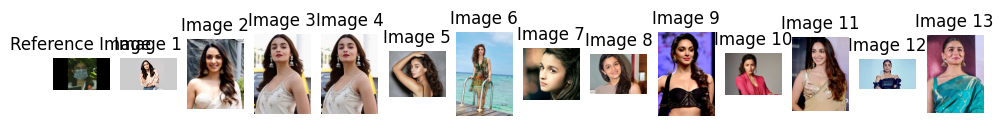

In [34]:
# Example usage
ref_img = 22
imgs = [12, 4, 8, 13, 5, 7, 6, 11, 10, 9, 15, 2, 14, 1, 3]

'''
Images numbered 1 to 12 and 22 are of Alia Bhatt.
Images numbered 13 to 21 are of Kiara Advani.
Images 21 and 22 feature individuals wearing masks.
In this exanple, most of the images are Alia's.
Ali's mask image is used as reference and found Alia's images
in the result with three Kirara's images.
'''

reference_image_path = imagePathGen(ref_img)[0]
image_paths = imagePathGen(imgs)

# Extract CLIP and facial features
reference_features = extract_clip_features([reference_image_path])
all_features = extract_clip_features(image_paths)

# Get cluster and plot images
cluster_images(reference_features, all_features, reference_image_path, image_paths, clip_weight=0.6, face_weight=0.5, upper_face_weight=0.3)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


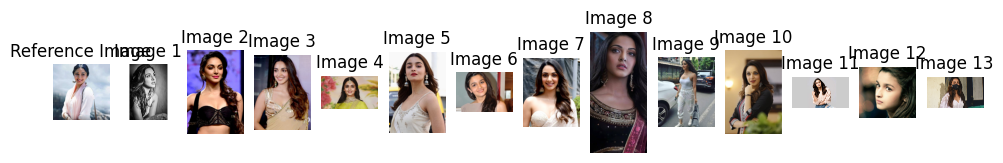

In [35]:
# Example usage
ref_img = 18
imgs = [16, 15, 14, 8, 11, 7, 9, 13, 17, 20, 19, 12, 10, 21]


'''
Images numbered 1 to 12 and 22 are of Alia Bhatt.
Images numbered 13 to 21 are of Kiara Advani.
Images 21 and 22 feature individuals wearing masks.
In this exanple, most of the images are Kiara's.
Reference is Kiara's one image.
Kiara's mask image is inclued and found in the result
with five Alia's images.
'''

reference_image_path = imagePathGen(ref_img)[0]
image_paths = imagePathGen(imgs)

# Extract CLIP and facial features
reference_features = extract_clip_features([reference_image_path])
all_features = extract_clip_features(image_paths)

# Get cluster and plot images
cluster_images(reference_features, all_features, reference_image_path, image_paths, clip_weight=0.6, face_weight=0.5, upper_face_weight=0.3)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


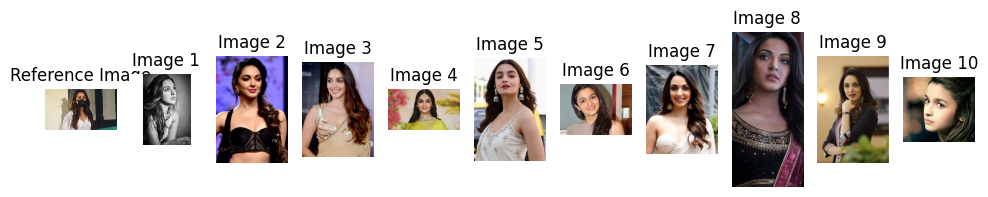

In [36]:
# Example usage
ref_img = 21
imgs = [16, 15, 14, 8, 11, 7, 9, 13, 17, 20, 19, 12, 10, 18]

'''
Images numbered 1 to 12 and 22 are of Alia Bhatt.
Images numbered 13 to 21 are of Kiara Advani.
Images 21 and 22 feature individuals wearing masks.
In this exanple, most of the images are Kiara's.
Kiara's mask image is used as reference and found only Kiara's other images in the result.
'''

reference_image_path = imagePathGen(ref_img)[0]
image_paths = imagePathGen(imgs)

# Extract CLIP and facial features
reference_features = extract_clip_features([reference_image_path])
all_features = extract_clip_features(image_paths)

# Get cluster and plot images
cluster_images(reference_features, all_features, reference_image_path, image_paths, clip_weight=0.6, face_weight=0.5, upper_face_weight=0.3)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


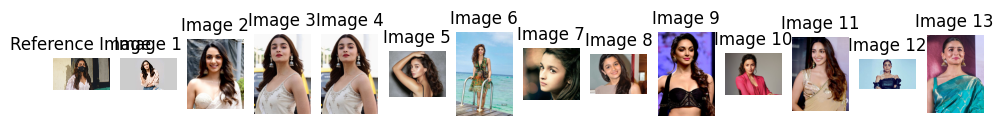

In [37]:
# Example usage
ref_img = 21
imgs = [12, 4, 8, 13, 5, 7, 6, 11, 10, 9, 15, 2, 14, 1, 3]

'''
Images numbered 1 to 12 and 22 are of Alia Bhatt.
Images numbered 13 to 21 are of Kiara Advani.
Images 21 and 22 feature individuals wearing masks.
In this exanple, most of the images are Alia's.
Kiara's mask image is used as reference and found both's images in the result.
'''

reference_image_path = imagePathGen(ref_img)[0]
image_paths = imagePathGen(imgs)

# Extract CLIP and facial features
reference_features = extract_clip_features([reference_image_path])
all_features = extract_clip_features(image_paths)

# Get cluster and plot images
cluster_images(reference_features, all_features, reference_image_path, image_paths, clip_weight=0.6, face_weight=0.5, upper_face_weight=0.3)

## Discussion:

The approach "*WIthout Deep Embedded Clustering*" is outperforming the one "*With Deep Embedded Clustering*". Human evaluation indicates **an error rate of approximately zero** in the results in the case of the approach without Deep Embedded Clustering, suggesting superior performance.